
#**Model Attempt #4: FINAL MODEL**

Improvments to be made:

ResNet50- deeper CNN, ImageNet training via Pytorch

Weights to handle data imbalance (CrossEntropyLoss)

Data transformation

Learning rate reducer

Early stopping

Model

In [ ]:
#load in libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from collections import Counter
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import random
import shutil
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread
import os
from imageio import imread

#stop warnings
import warnings
warnings.filterwarnings('ignore')

#from google.colab import drive
#drive.mount('/content/drive')
#!unzip -q /content/drive/MyDrive/dataset.zip -d /content/dataset
path = '/content/dataset/dataset'

In [9]:
#initialize
width = []
height = []
channel_color = []
weather_type = []

#set up path
for folder in os.listdir(path):
    subfolder_path = os.path.join(path, folder)
    for image_file in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_file)
        image = imread(image_path)
        if len(image.shape) < 3:
            image = image.reshape(image.shape + (1,))
        h, w, c = image.shape
        #update lists
        width.append(w)
        height.append(h)
        channel_color.append(c)
        weather_type.append(folder)

#make lists a df
df = pd.DataFrame({'width': width, 'height': height, 'channels': channel_color, 'weather': weather_type})
df.head()

,width,height,channels,weather
0,387,240,3,snow
1,400,270,4,snow
2,449,240,3,snow
3,400,280,3,snow
4,400,266,3,snow


Model

In [10]:
#make sure gpu is working
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(dev)

cuda


In [11]:
#import misc libraries; could be needed
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from collections import Counter
import copy

#transform
transformation_recipe1 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
transformation_recipe2 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

#get dataset and transform
weather_data = datasets.ImageFolder(path, transform = transformation_recipe1)

#weighted loss
labels = []
for i in weather_data:
    label = i[1]
    labels.append(label)
class_counts = Counter(labels)
total_samples = sum(class_counts.values())
class_weights = []
for i in range(len(weather_data.classes)):
    weight_amt = total_samples / class_counts[i]
    class_weights.append(weight_amt)

#split
train_size = int(0.8 * len(weather_data))
test_size = len(weather_data) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(weather_data, [train_size, test_size])

#transform test
test_dataset.dataset.transform = transformation_recipe2
load_train = DataLoader(train_dataset, batch_size = 32, shuffle = True)
load_test = DataLoader(test_dataset, batch_size = 32)

#model
resnet_model = models.resnet50(weights = models.ResNet50_Weights.IMAGENET1K_V1)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, len(weather_data.classes))
resnet_model = resnet_model.to(dev)

#optimize
crit = nn.CrossEntropyLoss(weight = torch.FloatTensor(class_weights).to(dev))
optimizer = optim.Adam(resnet_model.parameters(), lr = 0.0001)
lr_reducer = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.5, patience = 2)


#train
epochs = 15
best_test_acc = 0
p_counter = 0

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):

    resnet_model.train()
    running_loss = 0
    train_correct = 0
    train_total = 0

    for images, labels in load_train:
        images, labels = images.to(dev), labels.to(dev)
        optimizer.zero_grad()
        outputs = resnet_model(images)
        loss = crit(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, train_predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (train_predicted == labels).sum().item()

    avg_train_loss = running_loss / len(load_train)
    train_losses.append(avg_train_loss)
    train_acc = 100 * train_correct / train_total
    train_accuracies.append(train_acc)

    resnet_model.eval()
    correct, total, test_loss = 0, 0, 0
    with torch.no_grad():
        for images, labels in load_test:
            images, labels = images.to(dev), labels.to(dev)
            outputs = resnet_model(images)
            loss = crit(outputs, labels)
            test_loss += loss.item()
            predicted = torch.argmax(outputs, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_test_loss = test_loss / len(load_test)
    val_losses.append(avg_test_loss)

    test_acc = 100 * correct / total
    val_accuracies.append(test_acc)

    print(f"Epoch #{epoch+1}: Train Acc = {train_acc:.2f}%, Val Acc = {test_acc:.2f}%")

    lr_reducer.step(avg_test_loss)

    if test_acc > best_test_acc:
        best_test_acc = test_acc
        p_counter = 0
    else:
        p_counter += 1
        if p_counter >= 5:
            print("Early stopping triggered")
            break

print(f"Highest Validation Accuracy: {best_test_acc:.2f}%")


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 219MB/s]


Epoch #1: Train Acc = 82.97%, Val Acc = 87.40%
Epoch #2: Train Acc = 93.61%, Val Acc = 89.95%
Epoch #3: Train Acc = 95.35%, Val Acc = 88.64%
Epoch #4: Train Acc = 97.01%, Val Acc = 89.37%
Epoch #5: Train Acc = 97.12%, Val Acc = 90.82%
Epoch #6: Train Acc = 99.18%, Val Acc = 91.77%
Epoch #7: Train Acc = 99.56%, Val Acc = 91.26%
Epoch #8: Train Acc = 99.62%, Val Acc = 91.77%
Epoch #9: Train Acc = 99.91%, Val Acc = 92.72%
Epoch #10: Train Acc = 99.87%, Val Acc = 91.99%
Epoch #11: Train Acc = 99.96%, Val Acc = 92.13%
Epoch #12: Train Acc = 99.96%, Val Acc = 91.92%
Epoch #13: Train Acc = 99.93%, Val Acc = 91.99%
Epoch #14: Train Acc = 99.95%, Val Acc = 91.92%
Early stopping triggered
Highest Validation Accuracy: 92.72%


Graphs

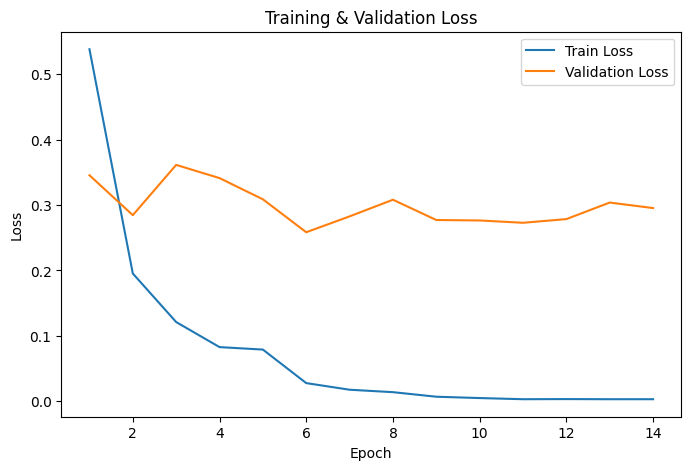

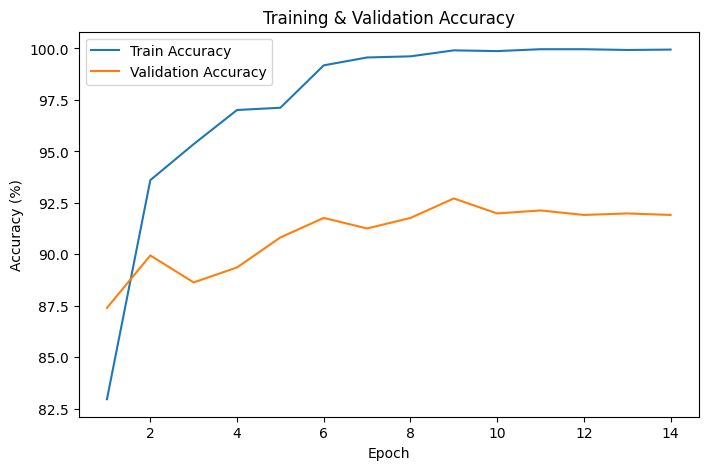

In [12]:
import matplotlib.pyplot as plt

#Loss Curve
plt.figure(figsize=(8,5))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()

#Accuracy Curve
plt.figure(figsize=(8,5))
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.show()


In [14]:
from sklearn.metrics import classification_report
import torch

resnet_model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in load_test:
        images, labels = images.to(dev), labels.to(dev)
        outputs = resnet_model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

#Print F1, precision, recall, and support for each class
print(classification_report(all_labels, all_preds, target_names=weather_data.classes))


              precision    recall  f1-score   support

         dew       0.95      0.96      0.95       146
     fogsmog       0.93      0.96      0.95       167
       frost       0.93      0.82      0.87       103
       glaze       0.79      0.82      0.81       113
        hail       0.95      1.00      0.97        97
   lightning       1.00      1.00      1.00        77
        rain       0.93      0.93      0.93       101
     rainbow       1.00      0.96      0.98        54
        rime       0.89      0.93      0.91       247
   sandstorm       0.93      0.95      0.94       149
        snow       0.90      0.78      0.84       119

    accuracy                           0.92      1373
   macro avg       0.93      0.92      0.92      1373
weighted avg       0.92      0.92      0.92      1373



In [15]:
report = classification_report(all_labels, all_preds, target_names=weather_data.classes, output_dict=True)

print("Weighted Metrics:")
print(f"F1-score: {report['weighted avg']['f1-score']:.4f}")
print(f"Precision: {report['weighted avg']['precision']:.4f}")
print(f"Recall: {report['weighted avg']['recall']:.4f}")
print(f"Support: {report['weighted avg']['support']}")


Weighted Metrics:
F1-score: 0.9185
Precision: 0.9196
Recall: 0.9192
Support: 1373.0


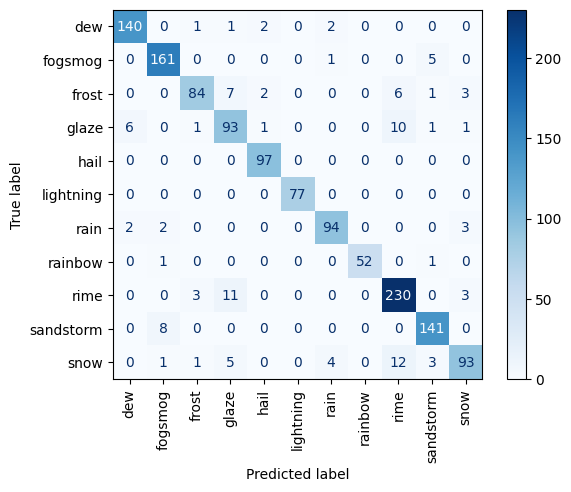

In [ ]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

resnet_model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in load_test:
        images, labels = images.to(dev), labels.to(dev)
        outputs = resnet_model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

#create confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(weather_data.classes))))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=weather_data.classes)
disp.plot(cmap='Blues', xticks_rotation='vertical')
